
### **Projeto 4 **

**Cenário:** Um cliente hipotético chega até você com uma carteira de investimentos "ingênua", montada sem critérios técnicos (por exemplo, com pesos iguais em cada ativo). Para melhorar, nós podemos:

1.  **Diagnosticar a Carteira Atual:** Analisar o risco (Volatilidade e VaR) e o retorno da carteira do cliente.
2.  **Propor uma Solução Otimizada:** Usar a Teoria de Markowitz para encontrar a alocação ideal para os *mesmos ativos* que o cliente já possui.
3.  **Quantificar a Melhoria:** Apresentar uma opção, mostrando os ganhos em termos de retorno ajustado ao risco (Índice de Sharpe) e a redução de perdas potenciais (VaR) da carteira otimizada em relação à original.

--- Inicializando o ambiente ---
Bibliotecas carregadas com sucesso.

--- PASSO 1: Definindo o cenário e coletando dados ---


/tmp/ipython-input-1-3309582288.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados_precos = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed


Dados de 4 ativos e do Ibovespa coletados de 2020-01-01 até 2025-06-27.
Ativos na carteira: ['ITUB4.SA', 'MGLU3.SA', 'VALE3.SA', 'WEGE3.SA']


--- PASSO 2: Analisando a carteira 'ingênua' do cliente ---
Diagnóstico da Carteira do Cliente (Pesos Iguais):
  - Retorno Anualizado: -5.86%
  - Volatilidade (Risco) Anual: 30.99%
  - Índice de Sharpe: -0.51
  - VaR Histórico (95%, 1 dia): -2.75% (perda diária potencial)


--- PASSO 3: Encontrando a carteira otimizada (Máximo Sharpe) ---
Simulação de Monte Carlo concluída. Carteira ótima encontrada.

--- PASSO 4: Analisando a carteira otimizada proposta ---
Diagnóstico da Carteira Otimizada (Proposta do Consultor):
  - Retorno Anualizado: 13.90%
  - Volatilidade (Risco) Anual: 31.42%
  - Índice de Sharpe: 0.12
  - VaR Histórico (95%, 1 dia): -2.64% (perda diária potencial)
  - Beta da Carteira vs. IBOV: 0.83


--- PASSO 5: Relatório Comparativo Final ---

**Comparativo de Desempenho e Risco:**

             Métrica Carteira do Cliente Carteira 

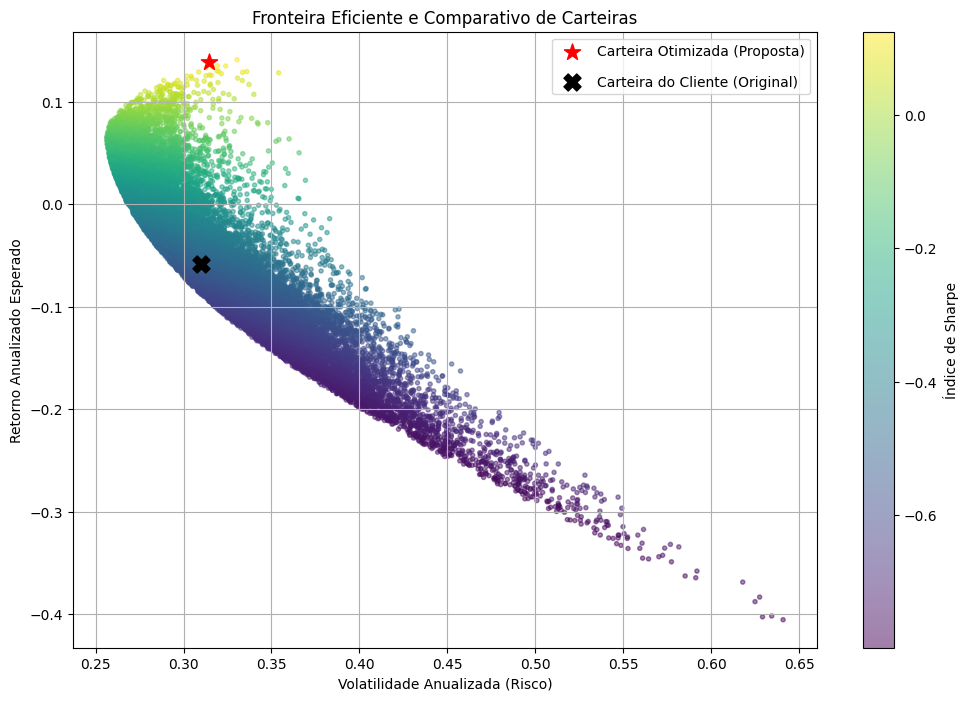

In [ ]:
# ==============================================================================
# PROJETO 4: ANÁLISE E OTIMIZAÇÃO DE CARTEIRA DE CLIENTE
# ==============================================================================

# PASSO 0: INSTALAÇÃO E IMPORTAÇÃO DAS BIBLIOTECAS
print("--- Inicializando o ambiente ---")
# Garante que as bibliotecas necessárias estão instaladas
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

print("Bibliotecas carregadas com sucesso.\n")

# ==============================================================================
# PASSO 1: CENÁRIO E COLETA DE DADOS
# ==============================================================================
print("--- PASSO 1: Definindo o cenário e coletando dados ---")

# Ativos do cliente + Ibovespa para cálculo do Beta
# Ativos do cliente do projeto de otimização para consistência
# Adicionamos o IBOV (^BVSP) para a análise final
tickers = ['VALE3.SA', 'ITUB4.SA', 'MGLU3.SA', 'WEGE3.SA', '^BVSP']
start_date = '2020-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d') # Usa a data atual

# Baixando os preços de fechamento
dados_precos = yf.download(tickers, start=start_date, end=end_date)['Close']
dados_precos.rename(columns={'^BVSP': 'IBOV'}, inplace=True)
dados_precos.dropna(inplace=True)

# Calcula os retornos logarítmicos diários.
retornos = np.log(dados_precos / dados_precos.shift(1)).dropna()

# Separa os retornos dos ativos e do Ibovespa
retornos_ativos = retornos.drop(columns=['IBOV'])
retornos_ibov = retornos['IBOV']
ativos = retornos_ativos.columns

print(f"Dados de {len(ativos)} ativos e do Ibovespa coletados de {start_date} até {end_date}.")
print("Ativos na carteira:", list(ativos))
print("\n")


# ==============================================================================
# PASSO 2: ANÁLISE DA CARTEIRA ATUAL DO CLIENTE
# ==============================================================================
print("--- PASSO 2: Analisando a carteira 'ingênua' do cliente ---")

# O cliente possui uma carteira com pesos iguais para cada ativo.
pesos_cliente = np.array([1/len(ativos)] * len(ativos))

# Calculo do retorno, volatilidade e Sharpe da carteira do cliente
retorno_medio_anual = retornos_ativos.mean() * 252
matriz_cov_anual = retornos_ativos.cov() * 252
taxa_livre_risco = 0.10 # Selic aproximada a.a.

retorno_cliente = np.sum(retorno_medio_anual * pesos_cliente)
volatilidade_cliente = np.sqrt(np.dot(pesos_cliente.T, np.dot(matriz_cov_anual, pesos_cliente)))
sharpe_cliente = (retorno_cliente - taxa_livre_risco) / volatilidade_cliente

# Calcula o VaR Histórico (95%) para a carteira do cliente
retornos_diarios_cliente = retornos_ativos.dot(pesos_cliente)
var_95_cliente = np.percentile(retornos_diarios_cliente, 5) # 5% piores cenários

print("Diagnóstico da Carteira do Cliente (Pesos Iguais):")
print(f"  - Retorno Anualizado: {retorno_cliente:.2%}")
print(f"  - Volatilidade (Risco) Anual: {volatilidade_cliente:.2%}")
print(f"  - Índice de Sharpe: {sharpe_cliente:.2f}")
print(f"  - VaR Histórico (95%, 1 dia): {var_95_cliente:.2%} (perda diária potencial)")
print("\n")


# ==============================================================================
# PASSO 3: OTIMIZAÇÃO DA CARTEIRA (TEORIA DE MARKOWITZ)
# ==============================================================================
print("--- PASSO 3: Encontrando a carteira otimizada (Máximo Sharpe) ---")

num_carteiras = 20000
resultados_carteiras = np.zeros((3, num_carteiras))
pesos_carteiras_lista = []

for i in range(num_carteiras):
    pesos = np.random.random(len(ativos))
    pesos /= np.sum(pesos)
    pesos_carteiras_lista.append(pesos)

    retorno_carteira = np.sum(retorno_medio_anual * pesos)
    volatilidade_carteira = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov_anual, pesos)))

    resultados_carteiras[0,i] = retorno_carteira
    resultados_carteiras[1,i] = volatilidade_carteira
    resultados_carteiras[2,i] = (retorno_carteira - taxa_livre_risco) / volatilidade_carteira

# Identifica a melhor carteira (maior Índice de Sharpe)
max_sharpe_idx = np.argmax(resultados_carteiras[2])
pesos_otimos = pesos_carteiras_lista[max_sharpe_idx]

print("Simulação de Monte Carlo concluída. Carteira ótima encontrada.\n")


# ==============================================================================
# PASSO 4: ANÁLISE DA CARTEIRA PROPOSTA ("CARTEIRA OTIMIZADA")
# ==============================================================================
print("--- PASSO 4: Analisando a carteira otimizada proposta ---")

# Pega os resultados da carteira ótima diretamente da simulação
retorno_otimizado = resultados_carteiras[0, max_sharpe_idx]
volatilidade_otimizada = resultados_carteiras[1, max_sharpe_idx]
sharpe_otimizado = resultados_carteiras[2, max_sharpe_idx]

# Calcula o VaR Histórico (95%) para a carteira otimizada
retornos_diarios_otimizados = retornos_ativos.dot(pesos_otimos)
var_95_otimizado = np.percentile(retornos_diarios_otimizados, 5)

# Calcula o Beta da carteira otimizada em relação ao Ibovespa
X = retornos_ibov.values.reshape(-1, 1)
y = retornos_diarios_otimizados.values.reshape(-1, 1)
modelo_beta = LinearRegression().fit(X, y)
beta_otimizado = modelo_beta.coef_[0][0]

print("Diagnóstico da Carteira Otimizada (Proposta do Consultor):")
print(f"  - Retorno Anualizado: {retorno_otimizado:.2%}")
print(f"  - Volatilidade (Risco) Anual: {volatilidade_otimizada:.2%}")
print(f"  - Índice de Sharpe: {sharpe_otimizado:.2f}")
print(f"  - VaR Histórico (95%, 1 dia): {var_95_otimizado:.2%} (perda diária potencial)")
print(f"  - Beta da Carteira vs. IBOV: {beta_otimizado:.2f}")
print("\n")


# ==============================================================================
# PASSO 5: RESULTADO FINAL - COMPARAÇÃO E RECOMENDAÇÃO
# ==============================================================================
print("--- PASSO 5: Relatório Comparativo Final ---")

# Criação de um DataFrame para visualização dos resultados
comparativo = pd.DataFrame({
    "Métrica": ["Retorno Anualizado", "Volatilidade (Risco)", "Índice de Sharpe", "VaR (95%, 1 dia)", "Beta da Carteira"],
    "Carteira do Cliente": [f"{retorno_cliente:.2%}", f"{volatilidade_cliente:.2%}", f"{sharpe_cliente:.2f}", f"{var_95_cliente:.2%}", "N/A"],
    "Carteira Otimizada (Proposta)": [f"{retorno_otimizado:.2%}", f"{volatilidade_otimizada:.2%}", f"{sharpe_otimizado:.2f}", f"{var_95_otimizado:.2%}", f"{beta_otimizado:.2f}"]
})

print("\n**Comparativo de Desempenho e Risco:**\n")
print(comparativo.to_string(index=False))

print("\n**Composição das Carteiras:**\n")
composicao = pd.DataFrame({
    "Ativo": ativos,
    "Peso Cliente": [f"{p:.2%}" for p in pesos_cliente],
    "Peso Otimizado": [f"{p:.2%}" for p in pesos_otimos]
})
print(composicao.to_string(index=False))

print("\n--- Conclusão da Consultoria ---")
print("A análise demonstra que, ao rebalancear os mesmos ativos através da Teoria Moderna do Portfólio,")
print(f"é possível construir uma carteira com um Índice de Sharpe superior ({sharpe_otimizado:.2f} vs {sharpe_cliente:.2f}).")
print("Isso significa obter um melhor retorno para cada unidade de risco assumido. Além disso, a nova carteira")
print(f"apresenta uma perda potencial diária (VaR 95%) de {var_95_otimizado:.2%}, em comparação com {var_95_cliente:.2%} da carteira original.")
print("Recomenda-se o rebalanceamento para a alocação otimizada para maximizar a eficiência do portfólio.")


# Plot da Fronteira Eficiente destacando as duas carteiras
plt.figure(figsize=(12, 8))
# Carteiras simuladas
plt.scatter(resultados_carteiras[1,:], resultados_carteiras[0,:], c=resultados_carteiras[2,:], cmap='viridis', marker='.', alpha=0.5)
plt.colorbar(label='Índice de Sharpe')
# Carteira Otimizada
plt.scatter(volatilidade_otimizada, retorno_otimizado, c='red', s=150, marker='*', label='Carteira Otimizada (Proposta)')
# Carteira do Cliente
plt.scatter(volatilidade_cliente, retorno_cliente, c='black', s=150, marker='X', label='Carteira do Cliente (Original)')

plt.title('Fronteira Eficiente e Comparativo de Carteiras')
plt.xlabel('Volatilidade Anualizada (Risco)')
plt.ylabel('Retorno Anualizado Esperado')
plt.legend(labelspacing=1.2)
plt.grid(True)
plt.show()